### Part 0 & 1

In [55]:
from torchtext import data, datasets
import torch
from sklearn.model_selection import train_test_split
import random
import numpy as np
import string
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import nltk
from nltk.corpus import stopwords
import seaborn as sns

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
from collections import defaultdict, Counter
import string

In [57]:
from sklearn.model_selection import KFold

In [58]:
# For tokenization
TEXT = data.Field(tokenize='spacy',
    tokenizer_language='en_core_web_sm',
    batch_first=True,
    fix_length=50,
    lower=True,
    unk_token='<unk>',
    pad_token='<pad>'
    )

# For multi-class classification labels
LABEL = data.LabelField()

# Load the TREC dataset
train_data, test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained=False)

In [59]:
label_set = set()
for i in train_data:
    label_set.add(i.label)

print(label_set)

{'DESC', 'LOC', 'ENTY', 'NUM', 'HUM', 'ABBR'}


In [60]:
TEXT.build_vocab(train_data, vectors="glove.6B.100d")
LABEL.build_vocab(train_data)

In [61]:
embedding_dim = 100
vocab = TEXT.vocab
vectors = vocab.vectors.clone()
glove_vocab = set(vocab.stoi.keys())

# Subword parameters
ngram_min = 3
ngram_max = 6

# Count word frequency in training data
word_counter = Counter()
for example in train_data:
    word_counter.update([w.lower().strip(string.punctuation) for w in example.text])

# Threshold to consider a word “frequent” (adjustable)
freq_threshold = 3

# <unk> vector
unk_vector = torch.zeros(embedding_dim)

def get_subwords(word, n_min=3, n_max=6):
    word = f"<{word.lower()}>"
    subwords = []
    for n in range(n_min, n_max+1):
        subwords += [word[i:i+n] for i in range(len(word)-n+1)]
    return subwords

def get_word_vector(word):
    w_clean = word.lower().strip(string.punctuation)
    
    if w_clean in glove_vocab:
        return vectors[vocab.stoi[w_clean]]
    
    # Subword averaging
    subwords = get_subwords(w_clean, ngram_min, ngram_max)
    subword_vecs = [vectors[vocab.stoi[sg]] for sg in subwords if sg in glove_vocab]
    if subword_vecs:
        return torch.stack(subword_vecs).mean(0)
    
    # Random vector for frequent OOVs
    if word_counter[w_clean] >= freq_threshold:
        return torch.randn(embedding_dim)
    
    # <unk> for rare OOVs
    return unk_vector

# Build embedding matrix
embedding_matrix = {}
for example in train_data:
    for w in example.text:
        if w not in embedding_matrix:
            embedding_matrix[w] = get_word_vector(w)

In [62]:
embedding_dim = 100
vocab = TEXT.vocab

# Create tensor for nn.Embedding
embedding_matrix_tensor = torch.zeros(len(vocab), embedding_dim)
for word, idx in vocab.stoi.items():
    if word in embedding_matrix:
        embedding_matrix_tensor[idx] = embedding_matrix[word]

# Create embedding layer (learnable)
embedding_layer = nn.Embedding.from_pretrained(embedding_matrix_tensor, freeze=False)
print("Embedding layer created with shape:", embedding_layer.weight.shape)


Embedding layer created with shape: torch.Size([8536, 100])


In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [64]:
import itertools, copy, pandas as pd


# RNN

### Libraries & Functions

In [65]:
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
embedding_dim = embedding_layer.weight.size(1)

In [ ]:
# Simple RNN classifier (tanh)
class RNNClassifier(nn.Module):
    def __init__(self, embedding_layer, hidden_dim, num_layers, bidirectional, dropout, num_classes):
        super().__init__()
        self.embedding = embedding_layer
        emb_dim = self.embedding.weight.size(1)
        self.rnn = nn.RNN(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            nonlinearity="tanh",      # simple RNN
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), num_classes)

    def forward(self, text):
        x = self.embedding(text)                     # [B, T, E]
        outputs, hidden = self.rnn(x)                # hidden: [L*D, B, H]
        if self.rnn.bidirectional:
            last = torch.cat((hidden[-2], hidden[-1]), dim=1)  # [B, 2H]
        else:
            last = hidden[-1]                                   # [B, H]
        return self.fc(self.dropout(last))

In [ ]:
import itertools, copy, random
import numpy as np
import torch
import torch.nn as nn
from torchtext import data
from sklearn.model_selection import KFold

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def build_iters(batch_size, train_data, valid_data, device):
    return data.BucketIterator.splits(
        (train_data, valid_data),
        batch_size=batch_size,
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        device=device
    )

def build_model(embedding_layer, pad_idx, hidden_dim, num_layers, bidirectional, dropout, num_classes, device):
    emb_layer = nn.Embedding.from_pretrained(
        embedding_layer.weight.data.clone(), freeze=False, padding_idx=pad_idx
    )
    model = RNNClassifier(
        embedding_layer=emb_layer,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        bidirectional=bidirectional,
        dropout=dropout,
        num_classes=num_classes
    ).to(device)
    return model

def epoch_run(iterator, model, criterion, optimizer=None):
    model.train(optimizer is not None)
    tot_loss, tot_correct, tot_count = 0.0, 0, 0
    for batch in iterator:
        text, labels = batch.text, batch.label
        logits = model(text)
        loss = criterion(logits, labels)
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
        tot_loss += loss.item() * labels.size(0)
        tot_correct += (logits.argmax(1) == labels).sum().item()
        tot_count += labels.size(0)
    return tot_loss / max(tot_count,1), tot_correct / max(tot_count,1)

# K-Fold training function
def train_kfold_config(k_folds, batch_size, lr, hidden_dim, *,
                       num_layers, bidirectional, dropout, num_classes,
                       full_dataset, pad_idx, device, embedding_layer,
                       max_epochs=50, patience=3, seed=42):

    set_seed(seed)  

    all_indices = np.arange(len(full_dataset))
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=seed)

    fold_results = []
    fold_models = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(all_indices), 1):
        print(f"\n===== Fold {fold}/{k_folds} =====")

        # Create new Dataset splits
        train_data = [full_dataset.examples[i] for i in train_idx]
        valid_data = [full_dataset.examples[i] for i in val_idx]
        train_data = data.Dataset(train_data, fields=full_dataset.fields)
        valid_data = data.Dataset(valid_data, fields=full_dataset.fields)

        # Build iterators
        train_iter, valid_iter = build_iters(batch_size, train_data, valid_data, device)

        # Build model, loss, optimizer
        model = build_model(embedding_layer, pad_idx, hidden_dim, num_layers, bidirectional, dropout, num_classes, device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        best_val_acc = -1.0
        epochs_no_improve = 0
        best_state = None

        # Train per fold
        for epoch in range(1, max_epochs + 1):
            train_loss, train_acc = epoch_run(train_iter, model, criterion, optimizer)
            val_loss, val_acc = epoch_run(valid_iter, model, criterion, optimizer=None)
            print(f"Epoch {epoch:02d}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                epochs_no_improve = 0
                best_state = copy.deepcopy(model.state_dict())
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print("Early stopping")
                    break

        if best_state:
            model.load_state_dict(best_state)

        print(f"Fold {fold} best val_acc={best_val_acc:.4f}")
        fold_results.append(best_val_acc)
        fold_models.append(model)

    mean_acc = np.mean(fold_results)
    print(f"\n===== K-Fold Results =====")
    for i, acc in enumerate(fold_results, 1):
        print(f"Fold {i}: {acc:.4f}")
    print(f"Average Val Accuracy: {mean_acc:.4f}")

    return mean_acc, fold_results, fold_models


## Skip here ownards (10 cells) -- might need to remove

In [13]:
# -----------------------------
# 1. Setup & Config
# -----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume TEXT, LABEL, train_data, test_data, embedding_layer already exist
train_data, valid_data = train_data.split(split_ratio=0.9, random_state=random.seed(SEED))
print(f"Train: {len(train_data)}, Valid: {len(valid_data)}, Test: {len(test_data)}")

PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
embedding_dim = embedding_layer.weight.size(1)

Train: 4416, Valid: 491, Test: 500


In [22]:
# -----------------------------
# Train/eval 1 epoch
# -----------------------------
def epoch_run(iterator, model, criterion, optimizer=None):
    model.train(optimizer is not None)
    tot_loss, tot_correct, tot_count = 0.0, 0, 0
    for batch in iterator:
        text, labels = batch.text, batch.label
        logits = model(text)
        loss = criterion(logits, labels)
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)  # RNNs can explode
            optimizer.step()
        tot_loss += loss.item() * labels.size(0)
        tot_correct += (logits.argmax(1) == labels).sum().item()
        tot_count += labels.size(0)
    return tot_loss / max(tot_count,1), tot_correct / max(tot_count,1)


In [ ]:
# -----------------------------
# Grid search with early stopping that SAVES BEST WEIGHTS
# -----------------------------
HIDDEN_DIM = 128
NUM_LAYERS = 1
BIDIRECTIONAL = True
DROPOUT = 0.3
NUM_CLASSES = len(LABEL.vocab)
MAX_EPOCHS = 20
PATIENCE = 3

PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

batch_sizes = [32, 64, 128]
learning_rates = [5e-4, 1e-3, 2e-3, 3e-3]

results = []

for bs, lr in itertools.product(batch_sizes, learning_rates):
    print(f"\n🔍 Testing BATCH={bs}, LR={lr}")
    train_iter, valid_iter = data.BucketIterator.splits(
        (train_data, valid_data),
        batch_size=bs,
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        device=device
    )

    # fresh embedding weights each trial
    emb_layer = nn.Embedding.from_pretrained(
        embedding_layer.weight.data.clone(), freeze=False, padding_idx=PAD_IDX
    )
    model = RNNClassifier(
        embedding_layer=emb_layer,
        hidden_dim=HIDDEN_DIM,
        num_layers=NUM_LAYERS,
        bidirectional=BIDIRECTIONAL,
        dropout=DROPOUT,
        num_classes=NUM_CLASSES
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_acc = -1.0
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(1, MAX_EPOCHS + 1):
        train_loss, train_acc = epoch_run(train_iter, model, criterion, optimizer)
        val_loss, val_acc = epoch_run(valid_iter, model, criterion, optimizer=None)
        print(f"Epoch {epoch:02d}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

        # ---- your early stopping block (with saving best) ----
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            best_model_state = copy.deepcopy(model.state_dict())  # keep BEST weights
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= PATIENCE:
                print("Early stopping")
                break

    # restore best weights before logging result (so this combo truly reflects its best)
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    results.append({"batch_size": bs, "lr": lr, "val_acc": best_val_acc})




🔍 Testing BATCH=32, LR=0.0005
Epoch 01: train_acc=0.6003, val_acc=0.7943
Epoch 02: train_acc=0.8252, val_acc=0.8411
Epoch 03: train_acc=0.8705, val_acc=0.8839
Epoch 04: train_acc=0.9017, val_acc=0.9063
Epoch 05: train_acc=0.9237, val_acc=0.8900
Epoch 06: train_acc=0.9386, val_acc=0.9022
Early stopping

🔍 Testing BATCH=32, LR=0.001
Epoch 01: train_acc=0.6771, val_acc=0.8534
Epoch 02: train_acc=0.8490, val_acc=0.8778
Epoch 03: train_acc=0.8961, val_acc=0.8982
Epoch 04: train_acc=0.9214, val_acc=0.9124
Epoch 05: train_acc=0.9450, val_acc=0.9022
Epoch 06: train_acc=0.9656, val_acc=0.8982
Early stopping

🔍 Testing BATCH=32, LR=0.002
Epoch 01: train_acc=0.7124, val_acc=0.8228
Epoch 02: train_acc=0.8594, val_acc=0.8676
Epoch 03: train_acc=0.9128, val_acc=0.8656
Epoch 04: train_acc=0.9402, val_acc=0.8574
Early stopping

🔍 Testing BATCH=32, LR=0.003
Epoch 01: train_acc=0.7251, val_acc=0.8513
Epoch 02: train_acc=0.8449, val_acc=0.8493
Epoch 03: train_acc=0.9096, val_acc=0.8676
Epoch 04: train_a

NameError: name 'pd' is not defined

In [27]:
df_results = pd.DataFrame(results).sort_values("val_acc", ascending=False)
best = df_results.iloc[0]
print("\n🏆 Best configuration:")
print(best)
print("\nAll results (sorted):\n", df_results.reset_index(drop=True))


🏆 Best configuration:
batch_size    32.000000
lr             0.001000
val_acc        0.912424
Name: 1, dtype: float64

All results (sorted):
     batch_size      lr   val_acc
0           32  0.0010  0.912424
1          128  0.0005  0.910387
2           64  0.0005  0.908350
3           32  0.0005  0.906314
4          128  0.0020  0.902240
5           64  0.0010  0.898167
6          128  0.0010  0.892057
7           64  0.0020  0.892057
8           64  0.0030  0.885947
9           32  0.0030  0.883910
10         128  0.0030  0.881874
11          32  0.0020  0.867617


In [ ]:
# --- 1) Fix best batch size & lr from your previous grid search result `best` ---
best_batch_size = int(best["batch_size"])
best_lr = float(best["lr"])
print(f"\n✅ Using best hyperparams from LR/Batch search -> batch_size={best_batch_size}, lr={best_lr}")

# --- 2) Hidden-dim search using fixed (batch_size, lr) ---

# Search space (tweak as you like)
hidden_dims = [64, 96, 128, 192, 256, 384, 512]

results_hd = []

# Rebuild iterators ONCE with best batch size
train_iter, valid_iter = data.BucketIterator.splits(
    (train_data, valid_data),
    batch_size=best_batch_size,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device
)

for hd in hidden_dims:
    print(f"\n🧪 Testing hidden_dim={hd}")

    # fresh embedding weights for each trial
    emb_layer = nn.Embedding.from_pretrained(
        embedding_layer.weight.data.clone(), freeze=False, padding_idx=PAD_IDX
    )

    model = RNNClassifier(
        embedding_layer=emb_layer,
        hidden_dim=hd,
        num_layers=NUM_LAYERS,
        bidirectional=BIDIRECTIONAL,
        dropout=DROPOUT,
        num_classes=NUM_CLASSES
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)

    best_val_acc_hd = -1.0
    epochs_no_improve = 0
    best_model_state_hd = None

    for epoch in range(1, MAX_EPOCHS + 1):
        train_loss, train_acc = epoch_run(train_iter, model, criterion, optimizer)
        val_loss, val_acc = epoch_run(valid_iter, model, criterion, optimizer=None)
        print(f"Epoch {epoch:02d}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

        # Early stopping + save-best (your pattern)
        if val_acc > best_val_acc_hd:
            best_val_acc_hd = val_acc
            epochs_no_improve = 0
            best_model_state_hd = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= PATIENCE:
                print("Early stopping")
                break

    # Restore best for this hidden_dim before recording
    if best_model_state_hd is not None:
        model.load_state_dict(best_model_state_hd)

    results_hd.append({"hidden_dim": hd, "val_acc": best_val_acc_hd})


In [ ]:
# --- 3) Pick best hidden dim, print & save variable ---
df_hd = pd.DataFrame(results_hd).sort_values("val_acc", ascending=False).reset_index(drop=True)
best_hidden_dim = int(df_hd.loc[0, "hidden_dim"])

print("\n🏆 Best hidden_dim configuration:")
print(df_hd.loc[0])
print("\nAll hidden_dim results (sorted):")
print(df_hd)

# Variables now set for subsequent training:
print(f"\n👉 Final choice: best_batch_size={best_batch_size}, best_lr={best_lr}, best_hidden_dim={best_hidden_dim}")

------------------

In [ ]:
import itertools, copy
import torch
import torch.nn as nn
import pandas as pd
from torchtext import data

# -----------------------------
# Generic helpers
# -----------------------------
def build_iters(batch_size, train_data, valid_data, device):
    return data.BucketIterator.splits(
        (train_data, valid_data),
        batch_size=batch_size,
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        device=device
    )

def build_model(embedding_layer, pad_idx, hidden_dim, num_layers, bidirectional, dropout, num_classes, device):
    emb_layer = nn.Embedding.from_pretrained(
        embedding_layer.weight.data.clone(), freeze=False, padding_idx=pad_idx
    )
    model = RNNClassifier(
        embedding_layer=emb_layer,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        bidirectional=bidirectional,
        dropout=dropout,
        num_classes=num_classes
    ).to(device)
    return model

def epoch_run(iterator, model, criterion, optimizer=None):
    model.train(optimizer is not None)
    tot_loss, tot_correct, tot_count = 0.0, 0, 0
    for batch in iterator:
        text, labels = batch.text, batch.label
        logits = model(text)
        loss = criterion(logits, labels)
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
        tot_loss   += loss.item() * labels.size(0)
        tot_correct += (logits.argmax(1) == labels).sum().item()
        tot_count  += labels.size(0)
    return tot_loss / max(tot_count,1), tot_correct / max(tot_count,1)

def train_one_config(batch_size, lr, hidden_dim, *,
                     num_layers, bidirectional, dropout, num_classes,
                     train_data, valid_data, pad_idx, device,
                     max_epochs=20, patience=3):
    """Train one (batch_size, lr, hidden_dim) with early stopping; return best_val_acc and best_state."""
    train_iter, valid_iter = build_iters(batch_size, train_data, valid_data, device)
    model = build_model(embedding_layer, pad_idx, hidden_dim, num_layers, bidirectional, dropout, num_classes, device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_acc = -1.0
    epochs_no_improve = 0
    best_state = None

    for epoch in range(1, max_epochs + 1):
        train_loss, train_acc = epoch_run(train_iter, model, criterion, optimizer)
        val_loss,   val_acc   = epoch_run(valid_iter, model, criterion, optimizer=None)
        print(f"Epoch {epoch:02d}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            best_state = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return best_val_acc, model


In [30]:
NUM_CLASSES   = len(LABEL.vocab)
NUM_LAYERS    = 1
BIDIRECTIONAL = True
DROPOUT       = 0.3
MAX_EPOCHS    = 20
PATIENCE      = 3

batch_sizes     = [32, 64, 128]
learning_rates  = [5e-4, 1e-3, 2e-3, 3e-3]
HIDDEN_DIM_FIXED = 128   # fixed while tuning (batch, lr)

results = []
for bs, lr in itertools.product(batch_sizes, learning_rates):
    print(f"\n🔍 Testing BATCH={bs}, LR={lr}")
    val_acc, _ = train_one_config(
        bs, lr, HIDDEN_DIM_FIXED,
        num_layers=NUM_LAYERS, bidirectional=BIDIRECTIONAL, dropout=DROPOUT, num_classes=NUM_CLASSES,
        train_data=train_data, valid_data=valid_data, pad_idx=PAD_IDX, device=device,
        max_epochs=MAX_EPOCHS, patience=PATIENCE
    )
    results.append({"batch_size": bs, "lr": lr, "val_acc": val_acc})

df_results = pd.DataFrame(results).sort_values("val_acc", ascending=False).reset_index(drop=True)
best = df_results.loc[0]
best_batch_size = int(best["batch_size"])
best_lr        = float(best["lr"])
print("\n🏆 Best (batch, lr):")
print(best)
print(f"\nSaved vars -> best_batch_size={best_batch_size}, best_lr={best_lr}")



🔍 Testing BATCH=32, LR=0.0005
Epoch 01: train_acc=0.6187, val_acc=0.8147
Epoch 02: train_acc=0.8102, val_acc=0.8391
Epoch 03: train_acc=0.8718, val_acc=0.8778
Epoch 04: train_acc=0.8981, val_acc=0.9043
Epoch 05: train_acc=0.9167, val_acc=0.8880
Epoch 06: train_acc=0.9366, val_acc=0.9043
Epoch 07: train_acc=0.9545, val_acc=0.8941
Early stopping

🔍 Testing BATCH=32, LR=0.001
Epoch 01: train_acc=0.6769, val_acc=0.8737
Epoch 02: train_acc=0.8406, val_acc=0.8635
Epoch 03: train_acc=0.9051, val_acc=0.8859
Epoch 04: train_acc=0.9282, val_acc=0.9022
Epoch 05: train_acc=0.9452, val_acc=0.8758
Epoch 06: train_acc=0.9654, val_acc=0.8859
Epoch 07: train_acc=0.9758, val_acc=0.8880
Early stopping

🔍 Testing BATCH=32, LR=0.002
Epoch 01: train_acc=0.6791, val_acc=0.8391
Epoch 02: train_acc=0.8576, val_acc=0.8819
Epoch 03: train_acc=0.9092, val_acc=0.8819
Epoch 04: train_acc=0.9466, val_acc=0.8819
Epoch 05: train_acc=0.9558, val_acc=0.9043
Epoch 06: train_acc=0.9817, val_acc=0.8900
Epoch 07: train_acc

In [31]:
hidden_dims = [64, 96, 128, 192, 256, 384, 512]
results_hd = []

for hd in hidden_dims:
    print(f"\n🧪 Testing hidden_dim={hd} (batch={best_batch_size}, lr={best_lr})")
    val_acc, _ = train_one_config(
        best_batch_size, best_lr, hd,
        num_layers=NUM_LAYERS, bidirectional=BIDIRECTIONAL, dropout=DROPOUT, num_classes=NUM_CLASSES,
        train_data=train_data, valid_data=valid_data, pad_idx=PAD_IDX, device=device,
        max_epochs=MAX_EPOCHS, patience=PATIENCE
    )
    results_hd.append({"hidden_dim": hd, "val_acc": val_acc})

df_hd = pd.DataFrame(results_hd).sort_values("val_acc", ascending=False).reset_index(drop=True)
best_hidden_dim = int(df_hd.loc[0, "hidden_dim"])
print("\n🏆 Best hidden_dim configuration:")
print(df_hd.loc[0])
print(f"\nSaved var -> best_hidden_dim={best_hidden_dim}")
print("\nAll hidden_dim results:\n", df_hd)



🧪 Testing hidden_dim=64 (batch=128, lr=0.0005)
Epoch 01: train_acc=0.3718, val_acc=0.4847
Epoch 02: train_acc=0.5661, val_acc=0.7006
Epoch 03: train_acc=0.6891, val_acc=0.7780
Epoch 04: train_acc=0.7538, val_acc=0.8086
Epoch 05: train_acc=0.8000, val_acc=0.8411
Epoch 06: train_acc=0.8379, val_acc=0.8554
Epoch 07: train_acc=0.8659, val_acc=0.8778
Epoch 08: train_acc=0.8915, val_acc=0.8819
Epoch 09: train_acc=0.9062, val_acc=0.8900
Epoch 10: train_acc=0.9214, val_acc=0.9002
Epoch 11: train_acc=0.9275, val_acc=0.8941
Epoch 12: train_acc=0.9418, val_acc=0.8900
Epoch 13: train_acc=0.9472, val_acc=0.8941
Early stopping

🧪 Testing hidden_dim=96 (batch=128, lr=0.0005)
Epoch 01: train_acc=0.3872, val_acc=0.5295
Epoch 02: train_acc=0.5942, val_acc=0.6802
Epoch 03: train_acc=0.7235, val_acc=0.7637
Epoch 04: train_acc=0.8030, val_acc=0.8411
Epoch 05: train_acc=0.8458, val_acc=0.8310
Epoch 06: train_acc=0.8755, val_acc=0.8880
Epoch 07: train_acc=0.8956, val_acc=0.8941
Epoch 08: train_acc=0.9101, v

## Continue here for kfold cross validation


### Q2 (a)

Find best batch_sizes and lr (with gradient clipping alrd)

In [ ]:
import itertools, numpy as np, pandas as pd

# fixed config
NUM_CLASSES   = len(LABEL.vocab)
NUM_LAYERS    = 1
BIDIRECTIONAL = True
DROPOUT       = 0.3
MAX_EPOCHS    = 50
PATIENCE      = 3
SEED          = 42
K_FOLDS       = 5

batch_sizes       = [32, 64, 128, 256]
learning_rates    = [5e-3, 1e-3, 5e-4, 1e-4 ]
HIDDEN_DIM_FIXED  = 128   # fixed while tuning (batch, lr)

FULL_DATASET = train_data   

results = []

for bs, lr in itertools.product(batch_sizes, learning_rates):
    print(f"\n🔍 K-Fold Testing BATCH={bs}, LR={lr}")
    mean_acc, fold_accs, fold_models = train_kfold_config(
        k_folds=K_FOLDS,
        batch_size=bs,
        lr=lr,
        hidden_dim=HIDDEN_DIM_FIXED,
        num_layers=NUM_LAYERS,
        bidirectional=BIDIRECTIONAL,
        dropout=DROPOUT,
        num_classes=NUM_CLASSES,
        full_dataset=FULL_DATASET,
        pad_idx=PAD_IDX,
        device=device,
        embedding_layer=embedding_layer,
        max_epochs=MAX_EPOCHS,
        patience=PATIENCE,
        seed=SEED
    )
    results.append({
        "batch_size": bs,
        "lr": lr,
        "cv_mean_acc": float(mean_acc),
        "cv_std": float(np.std(fold_accs)),
        "per_fold": [float(x) for x in fold_accs],  
    })

# Rank by mean CV acc (desc), then by lower std  as tie-breaker
df_results = (
    pd.DataFrame(results)
      .sort_values(["cv_mean_acc", "cv_std"], ascending=[False, True])
      .reset_index(drop=True)
)

best = df_results.loc[0]
best_batch_size = int(best["batch_size"])
best_lr         = float(best["lr"])

print("\n🏆 Best (batch, lr) by K-Fold:")
print(best[["batch_size","lr","cv_mean_acc","cv_std"]])
print(f"\nSaved vars -> best_batch_size={best_batch_size}, best_lr={best_lr}")



🔍 K-Fold Testing BATCH=32, LR=0.005

===== Fold 1/5 =====
Epoch 01: train_acc=0.5785, val_acc=0.7204
Epoch 02: train_acc=0.7624, val_acc=0.7809
Epoch 03: train_acc=0.8592, val_acc=0.8048
Epoch 04: train_acc=0.9037, val_acc=0.8268
Epoch 05: train_acc=0.9418, val_acc=0.8378
Epoch 06: train_acc=0.9663, val_acc=0.8332
Epoch 07: train_acc=0.9672, val_acc=0.8231
Epoch 08: train_acc=0.9704, val_acc=0.8249
Early stopping
Fold 1 best val_acc=0.8378

===== Fold 2/5 =====
Epoch 01: train_acc=0.6320, val_acc=0.7030
Epoch 02: train_acc=0.7608, val_acc=0.7663
Epoch 03: train_acc=0.8565, val_acc=0.8084
Epoch 04: train_acc=0.9204, val_acc=0.8057
Epoch 05: train_acc=0.9376, val_acc=0.7929
Epoch 06: train_acc=0.9587, val_acc=0.7956
Early stopping
Fold 2 best val_acc=0.8084

===== Fold 3/5 =====
Epoch 01: train_acc=0.5954, val_acc=0.7248
Epoch 02: train_acc=0.7423, val_acc=0.7798
Epoch 03: train_acc=0.8310, val_acc=0.7807
Epoch 04: train_acc=0.8783, val_acc=0.7633
Epoch 05: train_acc=0.9097, val_acc=0.8

Find best hidden dimension (with gradient clipping alrd)

In [ ]:
hidden_dims = [64, 96, 128, 192, 256, 384, 512]
results_hd = []

for hd in hidden_dims:
    print(f"\n🧪 K-Fold Testing hidden_dim={hd} (batch={best_batch_size}, lr={best_lr})")
    mean_acc, fold_accs, fold_models = train_kfold_config(
        k_folds=K_FOLDS,
        batch_size=best_batch_size,
        lr=best_lr,
        hidden_dim=hd,
        num_layers=NUM_LAYERS,
        bidirectional=BIDIRECTIONAL,
        dropout=DROPOUT,
        num_classes=NUM_CLASSES,
        full_dataset=train_data,     
        pad_idx=PAD_IDX,
        device=device,
        embedding_layer=embedding_layer,
        max_epochs=MAX_EPOCHS,
        patience=PATIENCE,
        seed=SEED
    )

    results_hd.append({
        "hidden_dim": hd,
        "cv_mean_acc": float(mean_acc),
        "cv_std": float(np.std(fold_accs)),
        "per_fold": [float(x) for x in fold_accs],
    })

df_hd = (
    pd.DataFrame(results_hd)
      .sort_values(["cv_mean_acc", "cv_std"], ascending=[False, True])
      .reset_index(drop=True)
)

best_hidden_dim = int(df_hd.loc[0, "hidden_dim"])

print("\n🏆 Best hidden_dim configuration (K-Fold):")
print(df_hd.loc[0, ["hidden_dim","cv_mean_acc","cv_std"]])
print(f"\nSaved var -> best_hidden_dim={best_hidden_dim}")

print("\nAll hidden_dim results:\n", df_hd)



🧪 K-Fold Testing hidden_dim=64 (batch=32, lr=0.001)

===== Fold 1/5 =====
Epoch 01: train_acc=0.5604, val_acc=0.7186
Epoch 02: train_acc=0.7562, val_acc=0.8011
Epoch 03: train_acc=0.8344, val_acc=0.8167
Epoch 04: train_acc=0.8863, val_acc=0.8423
Epoch 05: train_acc=0.9168, val_acc=0.8359
Epoch 06: train_acc=0.9482, val_acc=0.8405
Epoch 07: train_acc=0.9709, val_acc=0.8469
Epoch 08: train_acc=0.9837, val_acc=0.8442
Epoch 09: train_acc=0.9885, val_acc=0.8414
Epoch 10: train_acc=0.9927, val_acc=0.8561
Epoch 11: train_acc=0.9938, val_acc=0.8488
Epoch 12: train_acc=0.9984, val_acc=0.8478
Epoch 13: train_acc=0.9986, val_acc=0.8387
Early stopping
Fold 1 best val_acc=0.8561

===== Fold 2/5 =====
Epoch 01: train_acc=0.5641, val_acc=0.6929
Epoch 02: train_acc=0.7643, val_acc=0.7929
Epoch 03: train_acc=0.8377, val_acc=0.8112
Epoch 04: train_acc=0.8897, val_acc=0.8222
Epoch 05: train_acc=0.9266, val_acc=0.8249
Epoch 06: train_acc=0.9539, val_acc=0.8213
Epoch 07: train_acc=0.9700, val_acc=0.8277
E

### Q2 (b)

#### Regularization

#### might need to remove (14 cells)

In [68]:
best_batch_size = 32
best_lr = 0.001
best_hidden_dim = 96
K_FOLDS = 5
NUM_LAYERS    = 1
BIDIRECTIONAL = True
DROPOUT = 0.3
MAX_EPOCHS    = 50
PATIENCE      = 3
SEED          = 42
K_FOLDS       = 5
NUM_CLASSES   = len(LABEL.vocab)


No Regularization (No L2 No GC)

In [ ]:
def epoch_run_noclip(iterator, model, criterion, optimizer=None):
    model.train(optimizer is not None)
    tot_loss, tot_correct, tot_count = 0.0, 0, 0
    for batch in iterator:
        text, labels = batch.text, batch.label
        logits = model(text)
        loss = criterion(logits, labels)
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0) # no clipping
            optimizer.step()
        tot_loss += loss.item() * labels.size(0)
        tot_correct += (logits.argmax(1) == labels).sum().item()
        tot_count += labels.size(0)
    return tot_loss / max(tot_count,1), tot_correct / max(tot_count,1)

def train_kfold_config_NoReg(k_folds, batch_size, lr, hidden_dim, *,
                          num_layers, bidirectional, dropout, num_classes,
                          full_dataset, pad_idx, device, embedding_layer,
                          max_epochs=20, patience=3, seed=42):

    set_seed(SEED)
    all_indices = np.arange(len(full_dataset))
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=SEED)

    fold_results = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(all_indices), 1):
        print(f"\n===== Fold {fold}/{k_folds} (No regularization) =====")

        train_data = [full_dataset.examples[i] for i in train_idx]
        valid_data = [full_dataset.examples[i] for i in val_idx]
        train_data = data.Dataset(train_data, fields=full_dataset.fields)
        valid_data = data.Dataset(valid_data, fields=full_dataset.fields)

        train_iter, valid_iter = build_iters(batch_size, train_data, valid_data, device)

        model = build_model(embedding_layer, pad_idx, hidden_dim, num_layers,
                            bidirectional, dropout, num_classes, device)
        criterion = nn.CrossEntropyLoss()
        
        # L2 Regularization applied here
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        best_val_acc = -1.0
        best_state = None
        epochs_no_improve = 0

        for epoch in range(1, max_epochs + 1):
            train_loss, train_acc = epoch_run_noclip(train_iter, model, criterion, optimizer)
            val_loss, val_acc = epoch_run_noclip(valid_iter, model, criterion, optimizer=None)
            print(f"Epoch {epoch:02d}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                epochs_no_improve = 0
                best_state = copy.deepcopy(model.state_dict())
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print("Early stopping")
                    break

        if best_state:
            model.load_state_dict(best_state)

        print(f"Fold {fold} best val_acc={best_val_acc:.4f}")
        fold_results.append(best_val_acc)

    mean_acc = np.mean(fold_results)
    print(f"\nAverage Val Accuracy (No regularization): {mean_acc:.4f}")
    return mean_acc


In [70]:
mean_acc_no = train_kfold_config_NoReg(
    k_folds=K_FOLDS,
    batch_size=best_batch_size,
    lr=best_lr,
    hidden_dim=best_hidden_dim,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES,
    full_dataset=train_data,
    pad_idx=PAD_IDX,
    device=device,
    embedding_layer=embedding_layer,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    seed=SEED,
)
print(f"\nFinal K-Fold Mean Accuracy with No regularization: {mean_acc_no:.4f}")


===== Fold 1/5 (No regularization) =====
Epoch 01: train_acc=0.5737, val_acc=0.7314
Epoch 02: train_acc=0.7838, val_acc=0.7874
Epoch 03: train_acc=0.8491, val_acc=0.8268
Epoch 04: train_acc=0.9012, val_acc=0.8543
Epoch 05: train_acc=0.9335, val_acc=0.8524
Epoch 06: train_acc=0.9573, val_acc=0.8552
Epoch 07: train_acc=0.9743, val_acc=0.8552
Epoch 08: train_acc=0.9844, val_acc=0.8488
Epoch 09: train_acc=0.9890, val_acc=0.8341
Early stopping
Fold 1 best val_acc=0.8552

===== Fold 2/5 (No regularization) =====
Epoch 01: train_acc=0.5801, val_acc=0.7278
Epoch 02: train_acc=0.7794, val_acc=0.7974
Epoch 03: train_acc=0.8278, val_acc=0.7580
Epoch 04: train_acc=0.8776, val_acc=0.8497
Epoch 05: train_acc=0.9236, val_acc=0.8460
Epoch 06: train_acc=0.9553, val_acc=0.8194
Epoch 07: train_acc=0.9723, val_acc=0.8387
Early stopping
Fold 2 best val_acc=0.8497

===== Fold 3/5 (No regularization) =====
Epoch 01: train_acc=0.5724, val_acc=0.7578
Epoch 02: train_acc=0.7811, val_acc=0.7872
Epoch 03: train_

L2 Regularization (Weight Decay = 1e-4)

In [71]:
def train_kfold_config_L2(k_folds, batch_size, lr, hidden_dim, *,
                          num_layers, bidirectional, dropout, num_classes,
                          full_dataset, pad_idx, device, embedding_layer,
                          max_epochs=20, patience=3, seed=42, weight_decay=1e-4):

    set_seed(SEED)
    all_indices = np.arange(len(full_dataset))
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=SEED)

    fold_results = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(all_indices), 1):
        print(f"\n===== Fold {fold}/{k_folds} (L2 regularization) =====")

        train_data = [full_dataset.examples[i] for i in train_idx]
        valid_data = [full_dataset.examples[i] for i in val_idx]
        train_data = data.Dataset(train_data, fields=full_dataset.fields)
        valid_data = data.Dataset(valid_data, fields=full_dataset.fields)

        train_iter, valid_iter = build_iters(batch_size, train_data, valid_data, device)

        model = build_model(embedding_layer, pad_idx, hidden_dim, num_layers,
                            bidirectional, dropout, num_classes, device)
        criterion = nn.CrossEntropyLoss()
        
        # 👇 L2 Regularization applied here
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        best_val_acc = -1.0
        best_state = None
        epochs_no_improve = 0

        for epoch in range(1, max_epochs + 1):
            train_loss, train_acc = epoch_run_noclip(train_iter, model, criterion, optimizer)
            val_loss, val_acc = epoch_run_noclip(valid_iter, model, criterion, optimizer=None)
            print(f"Epoch {epoch:02d}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                epochs_no_improve = 0
                best_state = copy.deepcopy(model.state_dict())
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print("Early stopping")
                    break

        if best_state:
            model.load_state_dict(best_state)

        print(f"Fold {fold} best val_acc={best_val_acc:.4f}")
        fold_results.append(best_val_acc)

    mean_acc = np.mean(fold_results)
    print(f"\nAverage Val Accuracy (L2 regularization): {mean_acc:.4f}")
    return mean_acc


In [72]:
mean_acc_L2 = train_kfold_config_L2(
    k_folds=K_FOLDS,
    batch_size=best_batch_size,
    lr=best_lr,
    hidden_dim=best_hidden_dim,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES,
    full_dataset=train_data,
    pad_idx=PAD_IDX,
    device=device,
    embedding_layer=embedding_layer,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    seed=SEED,
    weight_decay=1e-4   # L2 penalty
)
print(f"\nFinal K-Fold Mean Accuracy with L2 regularization: {mean_acc_L2:.4f}")


===== Fold 1/5 (L2 regularization) =====
Epoch 01: train_acc=0.5714, val_acc=0.7177
Epoch 02: train_acc=0.7757, val_acc=0.7984
Epoch 03: train_acc=0.8367, val_acc=0.8268
Epoch 04: train_acc=0.8892, val_acc=0.8460
Epoch 05: train_acc=0.9264, val_acc=0.8607
Epoch 06: train_acc=0.9564, val_acc=0.8414
Epoch 07: train_acc=0.9729, val_acc=0.8579
Epoch 08: train_acc=0.9833, val_acc=0.8552
Early stopping
Fold 1 best val_acc=0.8607

===== Fold 2/5 (L2 regularization) =====
Epoch 01: train_acc=0.5735, val_acc=0.7067
Epoch 02: train_acc=0.7670, val_acc=0.7764
Epoch 03: train_acc=0.8347, val_acc=0.8167
Epoch 04: train_acc=0.8805, val_acc=0.8378
Epoch 05: train_acc=0.9234, val_acc=0.8460
Epoch 06: train_acc=0.9539, val_acc=0.8139
Epoch 07: train_acc=0.9723, val_acc=0.8112
Epoch 08: train_acc=0.9766, val_acc=0.8268
Early stopping
Fold 2 best val_acc=0.8460

===== Fold 3/5 (L2 regularization) =====
Epoch 01: train_acc=0.5697, val_acc=0.7633
Epoch 02: train_acc=0.7737, val_acc=0.8046
Epoch 03: train_

Gradient Clipping (clip_value=5.0)

In [ ]:
def train_kfold_config_gc(k_folds, batch_size, lr, hidden_dim, *,
                          num_layers, bidirectional, dropout, num_classes,
                          full_dataset, pad_idx, device, embedding_layer,
                          max_epochs=20, patience=3, seed=42):
    
    set_seed(SEED)
    all_indices = np.arange(len(full_dataset))
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=SEED)

    fold_results = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(all_indices), 1):
        print(f"\n===== Fold {fold}/{k_folds} (GC regularization) =====")

        train_data = [full_dataset.examples[i] for i in train_idx]
        valid_data = [full_dataset.examples[i] for i in val_idx]
        train_data = data.Dataset(train_data, fields=full_dataset.fields)
        valid_data = data.Dataset(valid_data, fields=full_dataset.fields)

        train_iter, valid_iter = build_iters(batch_size, train_data, valid_data, device)

        model = build_model(embedding_layer, pad_idx, hidden_dim, num_layers,
                            bidirectional, dropout, num_classes, device)
        criterion = nn.CrossEntropyLoss()
        
        # L2 Regularization applied here
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        best_val_acc = -1.0
        best_state = None
        epochs_no_improve = 0

        for epoch in range(1, max_epochs + 1):
            train_loss, train_acc = epoch_run(train_iter, model, criterion, optimizer)
            val_loss, val_acc = epoch_run(valid_iter, model, criterion, optimizer=None)
            print(f"Epoch {epoch:02d}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                epochs_no_improve = 0
                best_state = copy.deepcopy(model.state_dict())
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print("Early stopping")
                    break

        if best_state:
            model.load_state_dict(best_state)

        print(f"Fold {fold} best val_acc={best_val_acc:.4f}")
        fold_results.append(best_val_acc)

    mean_acc = np.mean(fold_results)
    print(f"\nAverage Val Accuracy (GC regularization): {mean_acc:.4f}")
    return mean_acc


In [74]:
mean_acc_gc = train_kfold_config_gc(
    k_folds=K_FOLDS,
    batch_size=best_batch_size,
    lr=best_lr,
    hidden_dim=best_hidden_dim,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES,
    full_dataset=train_data,
    pad_idx=PAD_IDX,
    device=device,
    embedding_layer=embedding_layer,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    seed=SEED,
)
print(f"\nFinal K-Fold Mean Accuracy with Gradient Clipping: {mean_acc_gc:.4f}")


===== Fold 1/5 (GC regularization) =====
Epoch 01: train_acc=0.5737, val_acc=0.7314
Epoch 02: train_acc=0.7838, val_acc=0.7874
Epoch 03: train_acc=0.8500, val_acc=0.8240
Epoch 04: train_acc=0.9009, val_acc=0.8524
Epoch 05: train_acc=0.9335, val_acc=0.8524
Epoch 06: train_acc=0.9569, val_acc=0.8497
Epoch 07: train_acc=0.9736, val_acc=0.8561
Epoch 08: train_acc=0.9842, val_acc=0.8488
Epoch 09: train_acc=0.9913, val_acc=0.8488
Epoch 10: train_acc=0.9954, val_acc=0.8469
Early stopping
Fold 1 best val_acc=0.8561

===== Fold 2/5 (GC regularization) =====
Epoch 01: train_acc=0.5753, val_acc=0.7269
Epoch 02: train_acc=0.7762, val_acc=0.7901
Epoch 03: train_acc=0.8354, val_acc=0.8286
Epoch 04: train_acc=0.8881, val_acc=0.8478
Epoch 05: train_acc=0.9298, val_acc=0.8368
Epoch 06: train_acc=0.9564, val_acc=0.8121
Epoch 07: train_acc=0.9684, val_acc=0.8093
Early stopping
Fold 2 best val_acc=0.8478

===== Fold 3/5 (GC regularization) =====
Epoch 01: train_acc=0.5587, val_acc=0.7431
Epoch 02: train_

L2 Regularization (Weight Decay = 1e-4) + Gradient Clipping (Clip value = 5.0)

In [ ]:
def train_kfold_config_L2_gc(k_folds, batch_size, lr, hidden_dim, *,
                          num_layers, bidirectional, dropout, num_classes,
                          full_dataset, pad_idx, device, embedding_layer,
                          max_epochs=20, patience=3, seed=42, weight_decay=1e-4):

    set_seed(SEED)
    all_indices = np.arange(len(full_dataset))
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=SEED)

    fold_results = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(all_indices), 1):
        print(f"\n===== Fold {fold}/{k_folds} (L2+GC regularization) =====")

        train_data = [full_dataset.examples[i] for i in train_idx]
        valid_data = [full_dataset.examples[i] for i in val_idx]
        train_data = data.Dataset(train_data, fields=full_dataset.fields)
        valid_data = data.Dataset(valid_data, fields=full_dataset.fields)

        train_iter, valid_iter = build_iters(batch_size, train_data, valid_data, device)

        model = build_model(embedding_layer, pad_idx, hidden_dim, num_layers,
                            bidirectional, dropout, num_classes, device)
        criterion = nn.CrossEntropyLoss()
        
        # L2 Regularization applied here
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        best_val_acc = -1.0
        best_state = None
        epochs_no_improve = 0

        for epoch in range(1, max_epochs + 1):
            train_loss, train_acc = epoch_run(train_iter, model, criterion, optimizer)
            val_loss, val_acc = epoch_run(valid_iter, model, criterion, optimizer=None)
            print(f"Epoch {epoch:02d}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                epochs_no_improve = 0
                best_state = copy.deepcopy(model.state_dict())
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print("Early stopping")
                    break

        if best_state:
            model.load_state_dict(best_state)

        print(f"Fold {fold} best val_acc={best_val_acc:.4f}")
        fold_results.append(best_val_acc)

    mean_acc = np.mean(fold_results)
    print(f"\nAverage Val Accuracy (L2+GC regularization): {mean_acc:.4f}")
    return mean_acc


In [76]:
mean_acc_L2_gc = train_kfold_config_L2_gc(
    k_folds=K_FOLDS,
    batch_size=best_batch_size,
    lr=best_lr,
    hidden_dim=best_hidden_dim,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES,
    full_dataset=train_data,
    pad_idx=PAD_IDX,
    device=device,
    embedding_layer=embedding_layer,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    seed=SEED,
    weight_decay=1e-4   # L2 penalty
)
print(f"\nFinal K-Fold Mean Accuracy with L2 regularization+Gradient Clipping: {mean_acc_L2_gc:.4f}")


===== Fold 1/5 (L2+GC regularization) =====
Epoch 01: train_acc=0.5714, val_acc=0.7177
Epoch 02: train_acc=0.7757, val_acc=0.7984
Epoch 03: train_acc=0.8358, val_acc=0.8258
Epoch 04: train_acc=0.8904, val_acc=0.8515
Epoch 05: train_acc=0.9246, val_acc=0.8570
Epoch 06: train_acc=0.9564, val_acc=0.8515
Epoch 07: train_acc=0.9702, val_acc=0.8405
Epoch 08: train_acc=0.9810, val_acc=0.8488
Early stopping
Fold 1 best val_acc=0.8570

===== Fold 2/5 (L2+GC regularization) =====
Epoch 01: train_acc=0.5735, val_acc=0.7067
Epoch 02: train_acc=0.7670, val_acc=0.7764
Epoch 03: train_acc=0.8354, val_acc=0.8167
Epoch 04: train_acc=0.8812, val_acc=0.8359
Epoch 05: train_acc=0.9234, val_acc=0.8313
Epoch 06: train_acc=0.9530, val_acc=0.8148
Epoch 07: train_acc=0.9695, val_acc=0.8323
Early stopping
Fold 2 best val_acc=0.8359

===== Fold 3/5 (L2+GC regularization) =====
Epoch 01: train_acc=0.5669, val_acc=0.7596
Epoch 02: train_acc=0.7753, val_acc=0.7853
Epoch 03: train_acc=0.8466, val_acc=0.8303
Epoch 0

Highest Val Accuracy from only using Weight Decay @ 0.8490

#### Below is for Train on whole training data and Test on test data 

Function

In [ ]:
def train_kfold_config_L2_or_gc(k_folds, batch_size, lr, hidden_dim, *,
                             num_layers, bidirectional, dropout, num_classes,
                             full_dataset, pad_idx, device, embedding_layer,
                             test_dataset, # pass test_data here
                             max_epochs=20, patience=3, seed=42,
                             weight_decay, clip_value, # L2 + GC knobs
                             retrain_val_ratio=0.1):       
    """
    K-Fold CV on training set (no test leakage) using L2 + gradient clipping.
    After CV, retrain on full train set (with small internal val split for early stopping),
    then evaluate once on the official test set. Returns (mean_cv_acc, test_acc).
    """
    def _set_seed(s):
        random.seed(s); np.random.seed(s)
        torch.manual_seed(s); torch.cuda.manual_seed_all(s)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    @torch.no_grad()
    def _evaluate(iterator, model, criterion):
        model.eval()
        tot_loss = tot_correct = tot_count = 0
        for batch in iterator:
            text, labels = batch.text, batch.label
            logits = model(text)
            loss = criterion(logits, labels)
            tot_loss   += loss.item() * labels.size(0)
            tot_correct += (logits.argmax(1) == labels).sum().item()
            tot_count  += labels.size(0)
        return tot_loss / max(tot_count,1), tot_correct / max(tot_count,1)

    def _train_epoch(it, model, criterion, optimizer, clip_value):
        model.train()
        tot_loss = tot_correct = tot_count = 0
        for batch in it:
            text, labels = batch.text, batch.label
            logits = model(text)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            if clip_value is not None:  # ✅ gradient clipping here
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            tot_loss   += loss.item() * labels.size(0)
            tot_correct += (logits.argmax(1) == labels).sum().item()
            tot_count  += labels.size(0)
        return tot_loss / max(tot_count,1), tot_correct / max(tot_count,1)

    _set_seed(seed)

    # Final retrain on FULL training set
    _set_seed(seed)
    n = len(full_dataset.examples)
    idx = np.arange(n)
    rng = np.random.default_rng(seed)
    rng.shuffle(idx)
    cut = int((1.0 - retrain_val_ratio) * n)
    tr_idx, va_idx = idx[:cut], idx[cut:]
    
    full_tr_ds = data.Dataset([full_dataset.examples[i] for i in tr_idx], fields=full_dataset.fields)
    full_va_ds = data.Dataset([full_dataset.examples[i] for i in va_idx], fields=full_dataset.fields)

    full_tr_iter, full_va_iter = build_iters(batch_size, full_tr_ds, full_va_ds, device)

    final_model = build_model(embedding_layer, pad_idx, hidden_dim, num_layers,
                              bidirectional, dropout, num_classes, device)
    criterion = nn.CrossEntropyLoss()
    if weight_decay is None:
        optimizer = torch.optim.Adam(final_model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(final_model.parameters(), lr=lr, weight_decay=weight_decay)

    best_state, best_val_acc, no_improve = None, -1.0, 0

    hist = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}
    for epoch in range(1, max_epochs + 1):
        tr_loss, tr_acc = _train_epoch(full_tr_iter, final_model, criterion, optimizer, clip_value)
        va_loss, va_acc = _evaluate(full_va_iter, final_model, criterion)
        print(f"[Final Retrain] Epoch {epoch:02d}: train_acc={tr_acc:.4f}, val_acc={va_acc:.4f}")
        hist["train_loss"].append(tr_loss); hist["train_acc"].append(tr_acc)
        hist["val_loss"].append(va_loss);   hist["val_acc"].append(va_acc)

        if va_acc > best_val_acc:
            best_val_acc, no_improve = va_acc, 0
            best_state = copy.deepcopy(final_model.state_dict())
        else:
            no_improve += 1
            if no_improve >= patience:
                print("[Final Retrain] Early stopping.")
                break

    if best_state is not None:
        final_model.load_state_dict(best_state)

    mean_acc = float(np.mean(hist["val_acc"]))

    # Evaluate once on TEST set
    test_iter = data.BucketIterator(
        test_dataset, batch_size=batch_size,
        sort_key=lambda x: len(x.text), sort_within_batch=True,
        device=device, train=False, shuffle=False
    )
    test_loss, test_acc = _evaluate(test_iter, final_model, criterion)

    return hist, mean_acc, float(test_acc)








In [ ]:
# Plot function
def plot_history(histories, title="Learning Curves"):
    plt.figure(figsize=(7,4))
    for name, h in histories.items():
        plt.plot(h["train_acc"], label=f"{name} - train acc")
        plt.plot(h["val_acc"],   label=f"{name} - val acc", linestyle="--")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(title + " (Accuracy)")
    plt.grid(True, alpha=0.4); plt.legend(); plt.show()

    plt.figure(figsize=(7,4))
    for name, h in histories.items():
        plt.plot(h["train_loss"], label=f"{name} - train loss")
        plt.plot(h["val_loss"],   label=f"{name} - val loss", linestyle="--")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(title + " (Loss)")
    plt.grid(True, alpha=0.4); plt.legend(); plt.show()


No Regularization 

[Final Retrain] Epoch 01: train_acc=0.5903, val_acc=0.7564
[Final Retrain] Epoch 02: train_acc=0.7850, val_acc=0.7912
[Final Retrain] Epoch 02: train_acc=0.7850, val_acc=0.7912
[Final Retrain] Epoch 03: train_acc=0.8557, val_acc=0.8242
[Final Retrain] Epoch 03: train_acc=0.8557, val_acc=0.8242
[Final Retrain] Epoch 04: train_acc=0.9077, val_acc=0.8571
[Final Retrain] Epoch 04: train_acc=0.9077, val_acc=0.8571
[Final Retrain] Epoch 05: train_acc=0.9466, val_acc=0.8626
[Final Retrain] Epoch 05: train_acc=0.9466, val_acc=0.8626
[Final Retrain] Epoch 06: train_acc=0.9647, val_acc=0.8516
[Final Retrain] Epoch 06: train_acc=0.9647, val_acc=0.8516
[Final Retrain] Epoch 07: train_acc=0.9782, val_acc=0.8370
[Final Retrain] Epoch 07: train_acc=0.9782, val_acc=0.8370
[Final Retrain] Epoch 08: train_acc=0.9878, val_acc=0.8571
[Final Retrain] Early stopping.

Train mean val acc=0.8297 | TEST acc=0.9020
[Final Retrain] Epoch 08: train_acc=0.9878, val_acc=0.8571
[Final Retrain] Early stopping.

Train

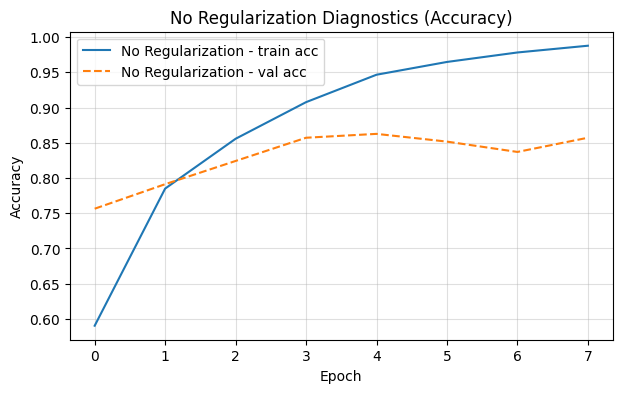

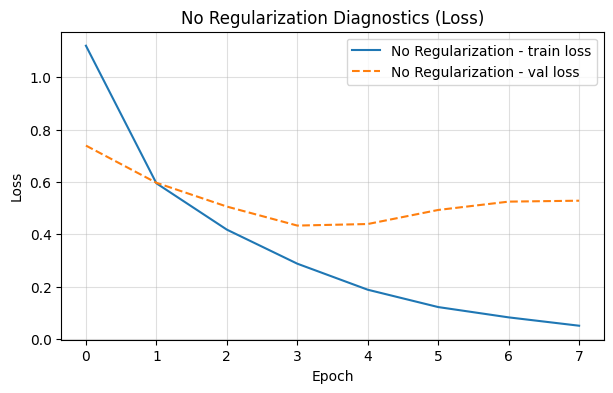

In [ ]:
hist, mean_acc_no, test_acc_no = train_kfold_config_L2_or_gc(
    k_folds=K_FOLDS,
    batch_size=best_batch_size,
    lr=best_lr,
    hidden_dim=best_hidden_dim,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES,
    full_dataset=train_data,    
    test_dataset=test_data,    
    pad_idx=PAD_IDX,
    device=device,
    embedding_layer=embedding_layer,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    seed=SEED,
    weight_decay=None, # L2
    clip_value=None # GC
)
print(f"\nTrain mean val acc={mean_acc_no:.4f} | TEST acc={test_acc_no:.4f}")
plot_history({"No Regularization": hist}, title="No Regularization Diagnostics")



L2 Regularization (Weight Decay = 1e-4)

[Final Retrain] Epoch 01: train_acc=0.5903, val_acc=0.7509
[Final Retrain] Epoch 02: train_acc=0.7797, val_acc=0.7949
[Final Retrain] Epoch 02: train_acc=0.7797, val_acc=0.7949
[Final Retrain] Epoch 03: train_acc=0.8520, val_acc=0.8150
[Final Retrain] Epoch 03: train_acc=0.8520, val_acc=0.8150
[Final Retrain] Epoch 04: train_acc=0.9052, val_acc=0.8425
[Final Retrain] Epoch 04: train_acc=0.9052, val_acc=0.8425
[Final Retrain] Epoch 05: train_acc=0.9405, val_acc=0.8516
[Final Retrain] Epoch 05: train_acc=0.9405, val_acc=0.8516
[Final Retrain] Epoch 06: train_acc=0.9580, val_acc=0.8480
[Final Retrain] Epoch 06: train_acc=0.9580, val_acc=0.8480
[Final Retrain] Epoch 07: train_acc=0.9733, val_acc=0.8370
[Final Retrain] Epoch 07: train_acc=0.9733, val_acc=0.8370
[Final Retrain] Epoch 08: train_acc=0.9845, val_acc=0.8407
[Final Retrain] Early stopping.

Train mean val acc=0.8226 | TEST acc=0.8880
[Final Retrain] Epoch 08: train_acc=0.9845, val_acc=0.8407
[Final Retrain] Early stopping.

Train

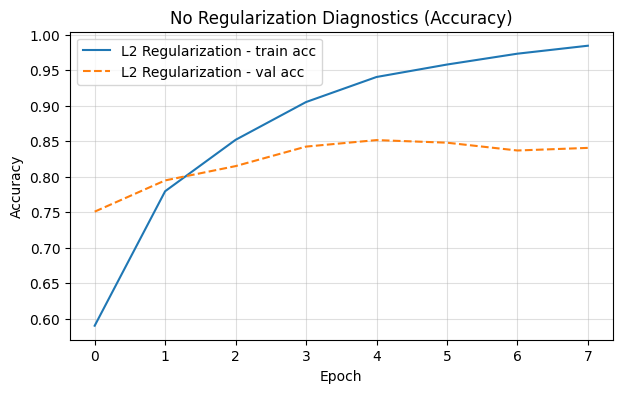

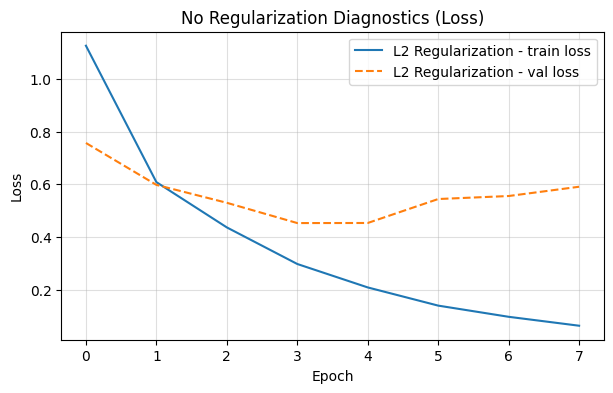

In [ ]:
hist, mean_acc_L2, test_acc_L2 = train_kfold_config_L2_or_gc(
    k_folds=K_FOLDS,
    batch_size=best_batch_size,
    lr=best_lr,
    hidden_dim=best_hidden_dim,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES,
    full_dataset=train_data,    
    test_dataset=test_data,     
    pad_idx=PAD_IDX,
    device=device,
    embedding_layer=embedding_layer,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    seed=SEED,
    weight_decay=1e-4, # L2
    clip_value=None # GC
)
print(f"\nTrain mean val acc={mean_acc_L2:.4f} | TEST acc={test_acc_L2:.4f}")
plot_history({"L2 Regularization": hist}, title="L2 Regularization Diagnostics")


Gradient Clipping (Clip value = 5.0)

[Final Retrain] Epoch 01: train_acc=0.5903, val_acc=0.7564
[Final Retrain] Epoch 02: train_acc=0.7848, val_acc=0.7912
[Final Retrain] Epoch 02: train_acc=0.7848, val_acc=0.7912
[Final Retrain] Epoch 03: train_acc=0.8555, val_acc=0.8242
[Final Retrain] Epoch 03: train_acc=0.8555, val_acc=0.8242
[Final Retrain] Epoch 04: train_acc=0.9087, val_acc=0.8516
[Final Retrain] Epoch 04: train_acc=0.9087, val_acc=0.8516
[Final Retrain] Epoch 05: train_acc=0.9458, val_acc=0.8590
[Final Retrain] Epoch 05: train_acc=0.9458, val_acc=0.8590
[Final Retrain] Epoch 06: train_acc=0.9639, val_acc=0.8516
[Final Retrain] Epoch 06: train_acc=0.9639, val_acc=0.8516
[Final Retrain] Epoch 07: train_acc=0.9772, val_acc=0.8315
[Final Retrain] Epoch 07: train_acc=0.9772, val_acc=0.8315
[Final Retrain] Epoch 08: train_acc=0.9855, val_acc=0.8553
[Final Retrain] Early stopping.

Train mean val acc=0.8276 | TEST acc=0.8980
[Final Retrain] Epoch 08: train_acc=0.9855, val_acc=0.8553
[Final Retrain] Early stopping.

Train

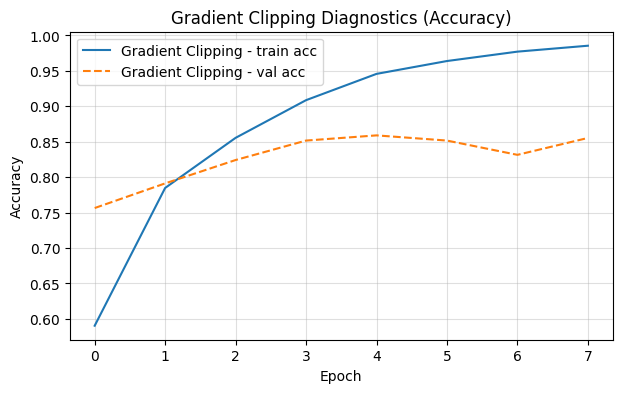

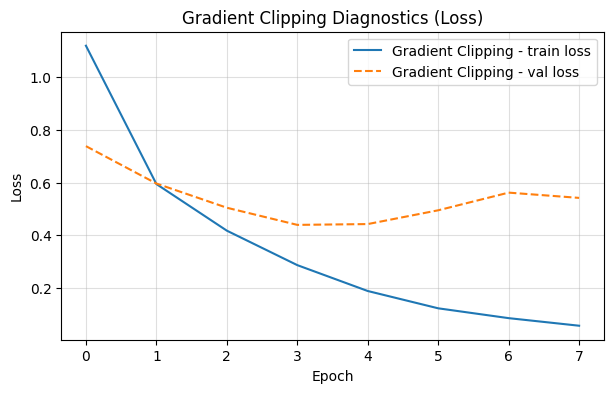

In [ ]:
hist, mean_acc_gc, test_acc_gc = train_kfold_config_L2_or_gc(
    k_folds=K_FOLDS,
    batch_size=best_batch_size,
    lr=best_lr,
    hidden_dim=best_hidden_dim,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES,
    full_dataset=train_data,
    test_dataset=test_data, 
    pad_idx=PAD_IDX,
    device=device,
    embedding_layer=embedding_layer,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    seed=SEED,
    weight_decay=None, # L2
    clip_value=5.0 # GC
)
print(f"\nTrain mean val acc={mean_acc_gc:.4f} | TEST acc={test_acc_gc:.4f}")
plot_history({"Gradient Clipping": hist}, title="Gradient Clipping Diagnostics")


L2 Regularization (Weight Decay = 1e-4) + Gradient Clipping (Clip value = 5.0)

[Final Retrain] Epoch 01: train_acc=0.5903, val_acc=0.7509
[Final Retrain] Epoch 02: train_acc=0.7797, val_acc=0.7949
[Final Retrain] Epoch 02: train_acc=0.7797, val_acc=0.7949
[Final Retrain] Epoch 03: train_acc=0.8532, val_acc=0.8260
[Final Retrain] Epoch 03: train_acc=0.8532, val_acc=0.8260
[Final Retrain] Epoch 04: train_acc=0.9056, val_acc=0.8443
[Final Retrain] Epoch 04: train_acc=0.9056, val_acc=0.8443
[Final Retrain] Epoch 05: train_acc=0.9429, val_acc=0.8462
[Final Retrain] Epoch 05: train_acc=0.9429, val_acc=0.8462
[Final Retrain] Epoch 06: train_acc=0.9619, val_acc=0.8516
[Final Retrain] Epoch 06: train_acc=0.9619, val_acc=0.8516
[Final Retrain] Epoch 07: train_acc=0.9749, val_acc=0.8462
[Final Retrain] Epoch 07: train_acc=0.9749, val_acc=0.8462
[Final Retrain] Epoch 08: train_acc=0.9857, val_acc=0.8553
[Final Retrain] Epoch 08: train_acc=0.9857, val_acc=0.8553
[Final Retrain] Epoch 09: train_acc=0.9912, val_acc=0.8297
[Final Retrain] Epoch 09: train_acc=0.9912, val_acc=0.82

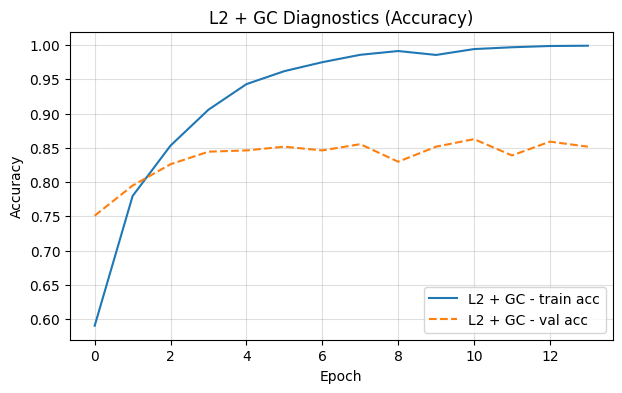

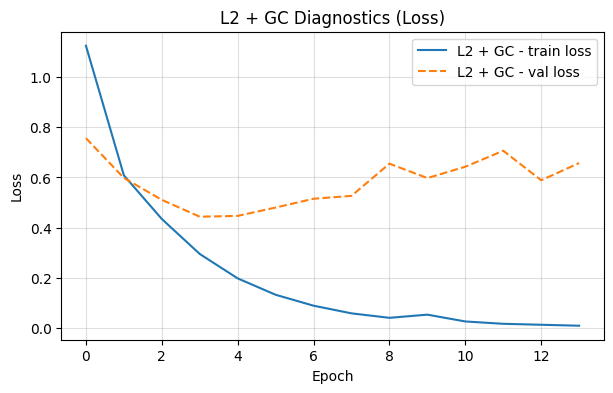

In [ ]:
hist, mean_acc_L2_gc, test_acc_L2_gc = train_kfold_config_L2_or_gc(
    k_folds=K_FOLDS,
    batch_size=best_batch_size,
    lr=best_lr,
    hidden_dim=best_hidden_dim,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES,
    full_dataset=train_data,
    test_dataset=test_data,
    pad_idx=PAD_IDX,
    device=device,
    embedding_layer=embedding_layer,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    seed=SEED,
    weight_decay=1e-4, # L2
    clip_value=5.0 # GC
)
print(f"\nTrain mean val acc={mean_acc_L2_gc:.4f} | TEST acc={test_acc_L2_gc:.4f}")
plot_history({"L2 + GC": hist}, title="L2 + GC Diagnostics")


In [61]:
acc = [test_acc_no, test_acc_L2, test_acc_gc, test_acc_L2_gc]
name = ["No Reg", "L2 Reg", "GC Reg", "L2+GC Reg"]
sorted_acc = sorted(acc, reverse=True)
print("\n🏆 Final Test Accuracies (sorted):")
for i, a in enumerate(sorted_acc):
    print(f"Rank {i+1}: {name[i]} | {a:.4f}")


🏆 Final Test Accuracies (sorted):
Rank 1: No Reg | 0.9020
Rank 2: L2 Reg | 0.8980
Rank 3: GC Reg | 0.8880
Rank 4: L2+GC Reg | 0.8840


Regularization in NLP is a technique to prevent models from overfitting by adding a penalty to the loss function or by constraining the model's complexity, which helps improve its ability to generalize to new, unseen data. 


#### Overall Logical Conclusion

Across all four configurations, the no-regularization model achieved the best test performance (0.902). This indicates that the model was not overfitting excessively on the TREC dataset. Regularization techniques such as L2 and gradient clipping reduced training variance but also limited learning capacity, causing mild underfitting. Combining both (L2 + GC) imposed excessive constraints, leading to the lowest test accuracy.


The training graphs show that when regularization is used, the model learns more slowly and reaches lower accuracy. The validation accuracy also stops improving earlier. This means the regularization made the model too cautious in which it couldn’t learn all the useful patterns. Because the dataset is small and the model isn’t too complex, regularization didn’t help it generalize better.

### Q2(c) -- best is No Regularization



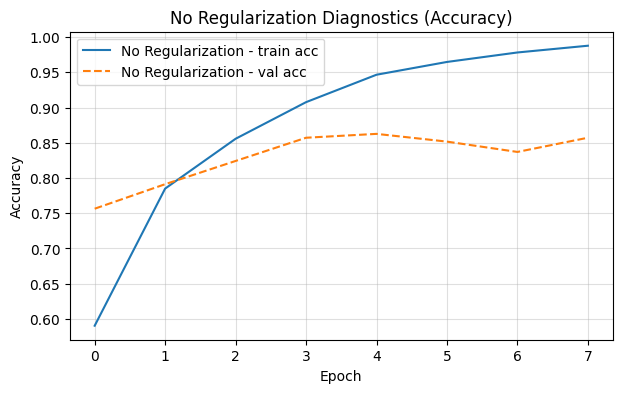

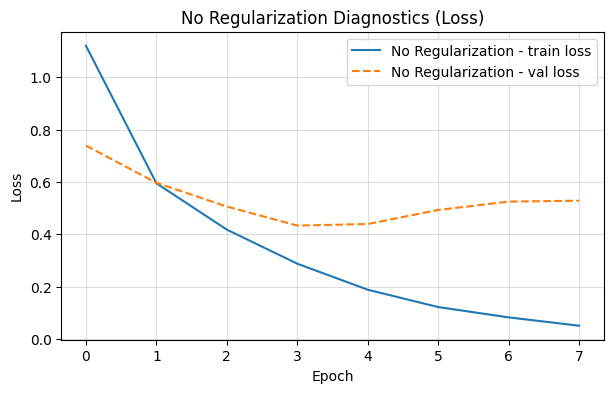

Plot of No-Regularization curves (the best model):

- Fast early learning. Train accuracy jumps quickly in the first few epochs → features/architecture fit the task well and the LR is reasonable.

- Diminishing returns. After epoch 3–4 the training curve flattens (approaches 1.0) → the model has mostly saturated capacity on the train set.

- Slight overfitting: The validation accuracy goes up until about epoch 4, then stops improving while the validation loss starts to increase a little. This shows the model is starting to learn small details from the training data that don’t help on new data (overfit).

- Stable training: The train loss keeps going down smoothly without sudden jumps, meaning the learning process is steady and gradients are stable.


In short: the model learns fast, then lightly overfits; early stopping at the peak val epoch is the right move, and extra regularization isn’t needed here.

### Q2(d)

RNN model that supports 3 methods (above we only used last method)

In [75]:
best_batch_size = 32
best_lr = 0.001
best_hidden_dim = 96
K_FOLDS = 5
NUM_LAYERS    = 1
BIDIRECTIONAL = True
DROPOUT = 0.3
MAX_EPOCHS    = 50
PATIENCE      = 3
SEED          = 42
K_FOLDS       = 5
NUM_CLASSES   = len(LABEL.vocab)
full_dataset = train_data
test_dataset = test_data
retrain_val_ratio=0.1

In [76]:
class RNNClassifier(nn.Module):
    def __init__(self, embedding_layer, hidden_dim, num_layers, bidirectional,
                 dropout, num_classes, pooling="last"):
        super().__init__()
        self.embedding = embedding_layer
        emb_dim = self.embedding.weight.size(1)

        self.rnn = nn.RNN(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            nonlinearity="tanh",
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), num_classes)

        assert pooling in ["last", "avg", "max"]
        self.pooling = pooling

    def forward(self, text):
        embedded = self.embedding(text)  # [batch, seq_len, emb_dim]
        outputs, hidden = self.rnn(embedded)  # outputs: [batch, seq_len, hidden*dirs]

        # Different sentence representations
        if self.pooling == "last":
            # last hidden state(s)
            if self.rnn.bidirectional:
                last = torch.cat((hidden[-2], hidden[-1]), dim=1)
            else:
                last = hidden[-1]
            rep = last

        elif self.pooling == "avg":
            rep = outputs.mean(dim=1)  # mean 

        elif self.pooling == "max":
            rep, _ = torch.max(outputs, dim=1)  # max 

        logits = self.fc(self.dropout(rep))
        return logits


In [82]:
def rnn_pooling(pooling_method):
    print(f"\n🔹 Running RNN ({pooling_method.upper()} pooling)")

    # rebuild embedding layer fresh each time
    emb_layer = nn.Embedding.from_pretrained(
        TEXT.vocab.vectors.clone(), freeze=False, padding_idx=PAD_IDX
    )

    model = RNNClassifier(
        embedding_layer=emb_layer,
        hidden_dim=best_hidden_dim,
        num_layers=NUM_LAYERS,
        bidirectional=BIDIRECTIONAL,
        dropout=DROPOUT,
        num_classes=NUM_CLASSES,
        pooling=pooling_method
    ).to(device)

    def _set_seed(s):
        random.seed(s); np.random.seed(s)
        torch.manual_seed(s); torch.cuda.manual_seed_all(s)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    _set_seed(SEED)
    n = len(full_dataset.examples)
    idx = np.arange(n)
    rng = np.random.default_rng(SEED)
    rng.shuffle(idx)
    cut = int((1.0 - retrain_val_ratio) * n)
    tr_idx, va_idx = idx[:cut], idx[cut:]
    
    full_tr_ds = data.Dataset([full_dataset.examples[i] for i in tr_idx], fields=full_dataset.fields)
    full_va_ds = data.Dataset([full_dataset.examples[i] for i in va_idx], fields=full_dataset.fields)

    full_tr_iter, full_va_iter = build_iters(best_batch_size, full_tr_ds, full_va_ds, device)


    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)

    best_val_acc, best_state, no_improve = -1.0, None, 0
    for epoch in range(1, MAX_EPOCHS + 1):
        train_loss, train_acc = epoch_run(full_tr_iter, model, criterion, optimizer)
        val_loss, val_acc = epoch_run(full_va_iter, model, criterion, optimizer=None)
        print(f"Epoch {epoch:02d}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc, no_improve, best_state = val_acc, 0, copy.deepcopy(model.state_dict())
        else:
            no_improve += 1
            if no_improve >= PATIENCE:
                print("Early stopping")
                break

    if best_state:
        model.load_state_dict(best_state)

    # --- Test evaluation ---
    test_iter = data.BucketIterator(
        test_dataset, batch_size=best_batch_size,
        sort_key=lambda x: len(x.text), sort_within_batch=True,
        device=device, train=False, shuffle=False
    )
    test_loss, test_acc = epoch_run(test_iter, model, criterion, optimizer=None)
    print(f"✅ TEST accuracy ({pooling_method.upper()}): {test_acc:.4f}\n")
    return test_acc


In [83]:
test_acc_last = rnn_pooling("last")
test_acc_avg  = rnn_pooling("avg")
test_acc_max  = rnn_pooling("max")

print("📊 Summary of Test Accuracies:")
print(f"Last Hidden State : {test_acc_last:.4f}")
print(f"Average Pooling   : {test_acc_avg:.4f}")
print(f"Max Pooling       : {test_acc_max:.4f}")



🔹 Running RNN (LAST pooling)
Epoch 01: train_acc=0.5915, val_acc=0.7454
Epoch 02: train_acc=0.7833, val_acc=0.7967
Epoch 03: train_acc=0.8587, val_acc=0.8205
Epoch 04: train_acc=0.9060, val_acc=0.8516
Epoch 05: train_acc=0.9470, val_acc=0.8553
Epoch 06: train_acc=0.9607, val_acc=0.8462
Epoch 07: train_acc=0.9698, val_acc=0.8626
Epoch 08: train_acc=0.9804, val_acc=0.8535
Epoch 09: train_acc=0.9870, val_acc=0.8553
Epoch 10: train_acc=0.9898, val_acc=0.8425
Early stopping
✅ TEST accuracy (LAST): 0.8740


🔹 Running RNN (AVG pooling)
Epoch 01: train_acc=0.3351, val_acc=0.3938
Epoch 02: train_acc=0.5135, val_acc=0.6648
Epoch 03: train_acc=0.6388, val_acc=0.6484
Epoch 04: train_acc=0.7369, val_acc=0.7198
Epoch 05: train_acc=0.7654, val_acc=0.7637
Epoch 06: train_acc=0.8194, val_acc=0.7692
Epoch 07: train_acc=0.8359, val_acc=0.7747
Epoch 08: train_acc=0.8710, val_acc=0.8004
Epoch 09: train_acc=0.8832, val_acc=0.7930
Epoch 10: train_acc=0.9115, val_acc=0.7875
Epoch 11: train_acc=0.9148, val_ac